# Momentum and AdaGrad 
Presented during ML reading group, 2019-11-12.

Author: Ivan Bogdan-Daniel, ibogdanidaniel@gmail.com

In [1]:
#%matplotlib notebook
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


print(f'Numpy version: {np.__version__}')

Numpy version: 1.17.3


# AdaDelta

The [AdaDelta paper](https://arxiv.org/pdf/1212.5701.pdf) 

The idea presented in this paper was derived from ADAGRAD in order to improve upon the two main drawbacks of the method:

1) the continual decay of learning rates throughout training

2) the need for a manually selected global learning rate. 



AdaGrad comes with:
$$w_{t+1}^{(j)} = w_{t}^{(j)} - \frac{\eta}{\sqrt{\varepsilon + \sum_{\tau=1}^{t}{(g_{\tau}^{(j)}})^2}} \nabla J_{w}(w_t^{(j)})$$
where $g_{\tau}$ is the gradient of error function at iteration $\tau$, $g_{\tau}^{(j)}$ is the partial derivative of the 
error function in direction of the $j$ - th feature, at iteration $\tau$, $m$ - is the number of features, i.e. 

The problem appears in the sum:

$${\varepsilon + \sum_{\tau=1}^{t}{(g_{\tau}^{(j)}})^2}$$

It grows into a very large number making the fraction $$\frac{\eta}{\sqrt{\varepsilon + \sum_{\tau=1}^{t}{(g_{\tau}^{(j)}})^2}}$$ become an insignificant number. The
learning rate will continue to decrease throughout training,
eventually decreasing to zero and stopping training completely. 






# Solution

Instead of accumulating the sum of squared gradients over all
time, we restricted the window of past gradients that are accumulated to be some fixed size w.

Since storing w previous squared gradients is inefficient,
our methods implements this accumulation as an exponentially decaying average of the squared gradients

This ensures that learning continues
to make progress even after many iterations of updates have
been done.

At time t this average is: $$E[g^2]_{t}$$ then we compute:

$$E[g^2]_{t}=\rho E[g^2]_{t-1}+(1-\rho)g^2_{t}$$

Where $\rho$ is a hyper parameter similar to the one used in momentum, it can take values between 0 and 1, generally 0.95 is recommended.

Since we require the square root of this quantity:

$$RMS[g]_{t} = \sqrt{E[g^2]_{t}+\epsilon}$$

The parameter update becomes:

$$w_{t+1}^{(j)} = w_{t}^{(j)} - \frac{\eta}{RMS[g]_{t}} g_{t}$$

AdaDelta rule:

$$w_{t+1}^{(j)} = w_{t}^{(j)} - \frac{RMS[\Delta w]_{t-1}}{RMS[g]_{t}} g_{t}$$

Where $RMS[\Delta w]_{t-1}$ is computed similar to $RMS[g]_{t}$

# Algorithm

Require: Decay rate $\rho$, Constant $\epsilon$

Require: Initial parameter x

<img src="./images/adadelta_algorithm.png" alt="drawing" width="600"/>

Source: [AdaDelta paper](https://arxiv.org/pdf/1212.5701.pdf) 


## Generate data

In [2]:
from scipy.sparse import random #to generate sparse data

np.random.seed(10) # for reproducibility
m_data = 100
n_data = 4 #number of features of the data
_scales = np.array([1,10, 10,1 ]) # play with these... 

_parameters = np.array([3, 0.5, 1, 7])

def gen_data(m, n, scales, parameters, add_noise=True):
    # Adagrad is designed especially for sparse data.
    # produce: X, a 2d tensor with m lines and n columns
    # and X[:, k] uniformly distributed in [-scale_k, scale_k] with the first and the last column containing sparse data 
    #(approx 75% of the elements are 0)
    #
    # To generate a sparse data matrix with m rows and n columns
    # and random values use S = random(m, n, density=0.25).A, where density = density of the data. S will be the 
    # resulting matrix 
    # more information at https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.random.html
    #
    # To obtain X - generate a random matrix with X[:, k] uniformly distributed in [-scale_k, scale_k]
    # set X[:, 0] and X[:, -1] to 0 and add matrix S with the sparse data.
    #
    # let y be X@parameters.T + epsilon, with epsilon ~ N(0, 1); y is a vector with m elements
    # parameters - the ideal weights, used to produce output values y
    #
    
    X = np.random.rand(m,n) *2*scales - scales
    X[:, 0] = 0
    X[:, -1] = 0
    S = random(m, n, density=0.25).A
    X = X + S
    y = X@parameters.T + np.random.randn(m)
    return X, y

In [3]:
X, y = gen_data(m_data, n_data, _scales, _parameters)
print(X)
print(y)

[[ 1.28428476e-01 -9.58496101e+00  3.03724491e+00  5.66402849e-01]
 [ 0.00000000e+00 -5.50406709e+00 -6.03874270e+00  0.00000000e+00]
 [ 0.00000000e+00 -8.23320372e+00  3.70719637e+00  0.00000000e+00]
 [ 0.00000000e+00  2.43845268e-01  6.25241923e+00  0.00000000e+00]
 [ 0.00000000e+00 -4.16247864e+00  8.35548245e+00  0.00000000e+00]
 [ 0.00000000e+00 -7.15659905e+00 -2.41271256e+00  0.00000000e+00]
 [ 0.00000000e+00 -8.76767173e-01  2.35533957e+00  0.00000000e+00]
 [ 0.00000000e+00  2.81450742e+00  6.92397429e+00  0.00000000e+00]
 [ 0.00000000e+00 -3.61527822e+00 -8.19081301e+00  0.00000000e+00]
 [ 0.00000000e+00  6.57362653e+00 -9.06207361e+00  0.00000000e+00]
 [ 0.00000000e+00  6.38573991e+00 -6.02104921e+00  0.00000000e+00]
 [ 8.70617442e-01  5.09295383e+00 -4.08076586e+00  0.00000000e+00]
 [ 0.00000000e+00 -6.69968205e+00 -1.60699768e+00  0.00000000e+00]
 [ 2.25025940e-01 -5.99602037e+00 -2.31771103e+00  0.00000000e+00]
 [ 0.00000000e+00 -8.73909058e-01  6.52245688e+00  0.00000000e

## Define error function, gradient, inference

In [4]:
def model_estimate(X, w):
    '''Computes the linear regression estimation on the dataset X, using coefficients w
    :param X: 2d tensor with m_data lines and n_data columns
    :param w: a 1d tensor with n_data coefficients (no intercept)
    :return: a 1d tensor with m_data elements y_hat = w @X.T
    '''
    y_hat = w@X.T
    return y_hat 

In [5]:
def J(X, y, w):
    """Computes the mean squared error of model. See the picture from last week's sheet.
    :param X: input values, of shape m_data x n_data
    :param y: ground truth, column vector with m_data values
    :param w: column with n_data coefficients for the linear form 
    :return: a scalar value >= 0
    :use the same formula as in the exercise from last week
    """
    m = X.shape[0]
    prod = model_estimate(X,w) - y
   
    err = (1.0/(2*m))*prod.T@prod
    return err

In [6]:
def gradient(X, y, w):
    '''Commputes the gradients to be used for gradient descent. 
    :param X: 2d tensor with training data
    :param y: 1d tensor with y.shape[0] == W.shape[0]
    :param w: 1d tensor with current values of the coefficients
    :return: gradients to be used for gradient descent. 
    :use the same formula as in the exercise from last week
    '''
    m = len(y)
    y_hat = model_estimate(X,w);
    grad = 1.0/m*X.T@(y_hat - y)
    return grad## implement

## Momentum algorithm

In [7]:
#The function from last week for comparison
def gd_with_momentum(X, y, w_init, eta=1e-1, gamma = 0.9, thresh = 0.001):
    """Applies gradient descent with momentum coefficient
    :params: as in gd_no_momentum
    :param gamma: momentum coefficient
    :param thresh: the threshold for gradient norm (to stop iterations)
    :return: the list of succesive errors and the found w* vector 
    """
    w = w_init
    w_err=[]
   
    delta = np.zeros_like(w)
    while True:
        grad = gradient(X, y, w)
        err = J(X, y, w)
        w_err.append(err)
        w_nou = w + gamma * delta - eta * grad
        delta = w_nou - w
        w = w_nou
       
        if np.linalg.norm(grad) < thresh :
            break;
    return w_err, w

In [8]:
w_init = np.array([0, 0, 0, 0])
errors_momentum, w_best = gd_with_momentum(X, y, w_init,0.0001, 0.9)

In [9]:
print(f'How many iterations were made: {len(errors_momentum)}')

How many iterations were made: 102146


In [10]:
w_best

array([2.96488751, 0.48443821, 0.9629436 , 7.32967655])

Text(0.5, 1.0, 'Optimization with momentum')

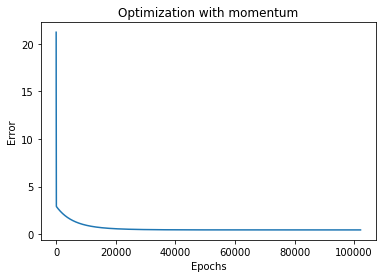

In [11]:
fig, axes = plt.subplots()
axes.plot(list(range(len(errors_momentum))), errors_momentum)
axes.set_xlabel('Epochs')
axes.set_ylabel('Error')
axes.set_title('Optimization with momentum')

## Apply AdaGrad and report resulting $\eta$'s

In [12]:
def ada_grad(X, y, w_init, eta_init=1e-1,  eps = 0.001, thresh = 0.001):
    '''Iterates with gradient descent. algorithm
    :param X: 2d tensor with data
    :param y: 1d tensor, ground truth 
    :param w_init: 1d tensor with the X.shape[1] initial coefficients
    :param eta_init: the initial learning rate hyperparameter
    :param eps: the epsilon value from the AdaGrad formula
    :param thresh: the threshold for gradient norm (to stop iterations)
    :return: the list of succesive errors w_err, the found w - the estimated feature vector 
    :and rates the learning rates after the final iteration 
    '''
     
    n = X.shape[1]
    w = w_init
    w_err=[]
   
    sum_sq_grad = np.zeros(n)
    rates = np.zeros(n)  + eta_init
    
    while True:
        grad = gradient(X, y, w)
        pgrad = grad**2
        err = J(X, y, w)
        w_err.append(err)
        prod = rates*grad
                
        w = w - prod
        sum_sq_grad += pgrad
        rates = eta_init/np.sqrt(eps + sum_sq_grad)
       
        
        if np.linalg.norm(grad) < thresh:
             break;
    return w_err, w, rates

In [13]:
w_init = np.array([0,0,0,0])
adaGerr, w_ada_best, rates = ada_grad(X, y, w_init)
print(rates)

[0.01515786 0.00157473 0.00021369 0.01046079]


In [14]:
print(f'How many iterations were made: {len(adaGerr)}')

How many iterations were made: 9106


In [15]:
w_ada_best

array([2.9633901 , 0.48443559, 0.96293089, 7.32943788])

Text(0.5, 1.0, 'Optimization with AdaGrad')

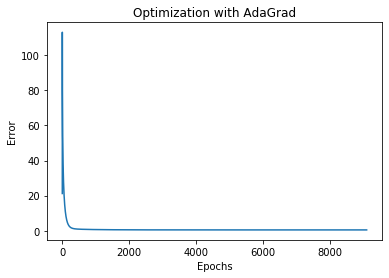

In [16]:
fig, axes = plt.subplots()
axes.plot(list(range(len(adaGerr))),adaGerr)
axes.set_xlabel('Epochs')
axes.set_ylabel('Error')
axes.set_title('Optimization with AdaGrad')

## Apply AdaDelta and report resulting $\eta$'s

In [17]:
def ada_delta(X, y, w_init, eta_init=1e-1, gamma=0.99,  eps = 0.001, thresh = 0.001):
    '''Iterates with gradient descent. algorithm
    :param X: 2d tensor with data
    :param y: 1d tensor, ground truth 
    :param w_init: 1d tensor with the X.shape[1] initial coefficients
    :param eta_init: the initial learning rate hyperparameter
    :param gamma: decay constant, similar to momentum
    :param eps: the epsilon value from the AdaGrad formula
    :param thresh: the threshold for gradient norm (to stop iterations)
    :return: the list of succesive errors w_err, the found w - the estimated feature vector 
    :and rates the learning rates after the final iteration 
    '''
     
    n = X.shape[1]
    w = w_init
    w_err=[]
   
    gradient_acc = np.zeros(n)
    update_acc = np.zeros(n)
    rates = np.zeros(n)  + eta_init
    
    while True:
        grad = gradient(X, y, w)
        err = J(X, y, w)
        w_err.append(err)
        
        gradient_acc = gamma*gradient_acc+(1-gamma)*grad**2
        update = - (np.sqrt(update_acc + eps) / np.sqrt(gradient_acc + eps))*grad
        update_acc = gamma*update_acc+(1-gamma)*update**2
        
        rates = eta_init/np.sqrt(eps + gradient_acc)
        w = w + update
       
        if np.linalg.norm(grad) < thresh:
             break;
    return w_err, w, rates

In [18]:
w_init = np.array([0,0,0,0])
adaDerr, w_adad_best, rates = ada_delta(X, y, w_init)
print(rates)

[1.92898329 0.154795   0.05150502 1.12628947]


In [19]:
print(f'How many iterations were made: {len(adaDerr)}')

How many iterations were made: 157


In [20]:
w_adad_best

array([2.96340998, 0.48443831, 0.96293207, 7.33043813])

Text(0.5, 1.0, 'Optimization with AdaDelta')

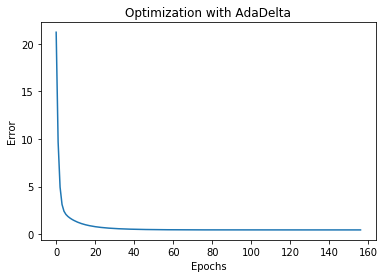

In [21]:
fig, axes = plt.subplots()
axes.plot(list(range(len(adaDerr))),adaDerr)
axes.set_xlabel('Epochs')
axes.set_ylabel('Error')
axes.set_title('Optimization with AdaDelta')